In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import warnings

warnings.filterwarnings("ignore")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 11

## 1. Load and Prepare Data

In [28]:
# Load the MOS results
df = pd.read_csv("../results/mos_results.csv")
df["model_name"] = df["model_name"].str.replace("GT-000000", "Ground Truth")
df = df[df["model_name"] != "Ground Truth"].reset_index(drop=True)

# Display first few rows and basic info
print("\nColumn names:")
df.columns


Column names:


Index(['user_email_hash', 'model_name', 'phrase_id', 'speaker_id', 'rating'], dtype='object')

In [29]:
df.describe(include="all")

,user_email_hash,model_name,phrase_id,speaker_id,rating
count,1080,1080,1080,1080,1080.000000
unique,21,6,60,6,NaN
top,1bff70e1,Tacotron2-180spk,p055,VP427,NaN
freq,52,180,18,180,NaN
mean,NaN,NaN,NaN,NaN,2.598148
std,NaN,NaN,NaN,NaN,1.158279
min,NaN,NaN,NaN,NaN,1.000000
25%,NaN,NaN,NaN,NaN,2.000000
50%,NaN,NaN,NaN,NaN,2.000000
75%,NaN,NaN,NaN,NaN,3.000000


## 2. Calculate MOS Scores with 95% Confidence Intervals

Using the Student's t-distribution:
$$CI = \bar{x} \pm t_{0.975, N-1} \cdot \frac{s}{\sqrt{N}}$$

In [30]:
def calculate_mos_with_ci(ratings, confidence=0.95):
    """Calculate MOS score with confidence interval using t-distribution."""
    n = len(ratings)
    mean = np.mean(ratings)
    std = np.std(ratings, ddof=1)
    se = std / np.sqrt(n)
    t_crit = stats.t.ppf((1 + confidence) / 2, n - 1)
    ci = t_crit * se

    return {
        "MOS": mean,
        "std": std,
        "n": n,
        "CI_lower": mean - ci,
        "CI_upper": mean + ci,
        "CI_margin": ci,
    }


# Calculate MOS for each model
mos_results = (
    df.groupby("model_name")["rating"].apply(calculate_mos_with_ci).unstack().round(3)
)

print("\n" + "=" * 80)
print("MOS RESULTS WITH 95% CONFIDENCE INTERVALS")
print("=" * 80)
print(mos_results)

print("\n" + "=" * 80)
print("FORMATTED FOR THESIS (LaTeX)")
print("=" * 80)
for model, row in mos_results.iterrows():
    print(f"{model} & {row['MOS']:.2f} $\\pm$ {row['CI_margin']:.2f} \\\\")


MOS RESULTS WITH 95% CONFIDENCE INTERVALS
                    MOS    std      n  CI_lower  CI_upper  CI_margin
model_name                                                          
Glow-030spk       2.128  0.812  180.0     2.008     2.247      0.119
Glow-060spk       2.178  1.042  180.0     2.025     2.331      0.153
Glow-180spk       2.028  0.948  180.0     1.888     2.167      0.139
Tacotron2-030spk  3.106  1.086  180.0     2.946     3.265      0.160
Tacotron2-060spk  3.122  1.171  180.0     2.950     3.294      0.172
Tacotron2-180spk  3.028  1.203  180.0     2.851     3.205      0.177

FORMATTED FOR THESIS (LaTeX)
Glow-030spk & 2.13 $\pm$ 0.12 \\
Glow-060spk & 2.18 $\pm$ 0.15 \\
Glow-180spk & 2.03 $\pm$ 0.14 \\
Tacotron2-030spk & 3.11 $\pm$ 0.16 \\
Tacotron2-060spk & 3.12 $\pm$ 0.17 \\
Tacotron2-180spk & 3.03 $\pm$ 0.18 \\


## 3. Statistical Significance Testing

### 3.1 One-Way ANOVA

Test the null hypothesis that all models have the same mean MOS.

In [34]:
# Prepare data for ANOVA
groups = [
    group["rating"].values
    for name, group in df.groupby("model_name")
    # if name.startswith("Tacotron")
]
model_names = df["model_name"].unique()

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*groups)

print("\n" + "=" * 80)
print("ONE-WAY ANOVA RESULTS")
print("=" * 80)
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.6f}")


ONE-WAY ANOVA RESULTS
F-statistic: 46.8490
p-value: 0.000000


### 3.2 Tukey's HSD Post-Hoc Test

Identify which specific pairs of models differ significantly.

In [36]:
# Perform Tukey's HSD test
tukey_result = pairwise_tukeyhsd(df["rating"], df["model_name"], alpha=0.05)

# Convert to DataFrame
tukey_df = pd.DataFrame(
    data=tukey_result.summary().data[1:], columns=tukey_result.summary().data[0]
)

# Show only significant pairs
significant_pairs = tukey_df[tukey_df["reject"] == True]
print("\n" + "=" * 80)
print("SIGNIFICANT PAIRWISE DIFFERENCES (α=0.05)")
print("=" * 80)
print(significant_pairs[["group1", "group2", "meandiff", "p-adj"]])


SIGNIFICANT PAIRWISE DIFFERENCES (α=0.05)
         group1            group2  meandiff  p-adj
2   Glow-030spk  Tacotron2-030spk    0.9778    0.0
3   Glow-030spk  Tacotron2-060spk    0.9944    0.0
4   Glow-030spk  Tacotron2-180spk    0.9000    0.0
6   Glow-060spk  Tacotron2-030spk    0.9278    0.0
7   Glow-060spk  Tacotron2-060spk    0.9444    0.0
8   Glow-060spk  Tacotron2-180spk    0.8500    0.0
9   Glow-180spk  Tacotron2-030spk    1.0778    0.0
10  Glow-180spk  Tacotron2-060spk    1.0944    0.0
11  Glow-180spk  Tacotron2-180spk    1.0000    0.0


## 6. LaTeX Summary Statistics

Extract all key values needed for the results section of the thesis.

In [37]:
df = df[df["model_name"] != "Ground Truth"].reset_index(drop=True)

In [38]:
# ============================================================================
# KEY STATISTICS FOR LATEX RESULTS SECTION
# ============================================================================

print("=" * 80)
print("LATEX RESULTS SUMMARY")
print("=" * 80)

# 1. Sample size and participant information
total_ratings = len(df)
unique_raters = df["user_email_hash"].nunique()
num_models = df["model_name"].nunique()

print("\n### SAMPLE INFORMATION ###")
print(f"Total ratings collected: {total_ratings}")
print(f"Number of unique raters: {unique_raters}")
print(f"Number of models evaluated: {num_models}")
print(f"Rating scale: 1-5")

# 2. Rating distribution
print("\n### RATING DISTRIBUTION ###")
rating_dist = df["rating"].value_counts().sort_index()
for rating, count in rating_dist.items():
    pct = 100 * count / total_ratings
    print(f"Rating {rating}: {count} ({pct:.1f}%)")

# 3. MOS Results Table
print("\n### MOS SCORES WITH 95% CONFIDENCE INTERVALS ###")
print("\nFormatted for LaTeX table:")
print("-" * 60)
for model, row in mos_results.iterrows():
    print(f"{model} & {row['MOS']:.2f} $\\pm$ {row['CI_margin']:.2f} \\\\")

# 4. ANOVA Results
print("\n### ONE-WAY ANOVA ###")
# Calculate degrees of freedom
df_between = len(groups) - 1
df_within = total_ratings - len(groups)
print(f"F({df_between}, {df_within}) = {f_stat:.4f}, p < 0.001")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.10f}")

# 5. Tukey's HSD Results
print("\n### TUKEY'S HSD POST-HOC TEST ###")
num_significant = len(significant_pairs)
total_comparisons = len(tukey_df)
print(f"Number of significant pairwise differences (α=0.05): {num_significant} out of {total_comparisons}")

# 6. Top performing models
print("\n### TOP 3 PERFORMING MODELS ###")
top_models = mos_results.nlargest(3, "MOS")
for i, (model, row) in enumerate(top_models.iterrows(), 1):
    print(f"{i}. {model}: {row['MOS']:.2f} ± {row['CI_margin']:.2f}")

# 7. Architecture comparison summary
print("\n### ARCHITECTURE COMPARISON ###")
# Filter out ground truth
exp_results = mos_results[mos_results.index.str.contains("spk", case=False)].copy()
exp_results["Architecture"] = exp_results.index.map(lambda x: parse_model_name(x)[0])
exp_results["Speakers"] = exp_results.index.map(lambda x: parse_model_name(x)[1])

# Average MOS by architecture
arch_summary = exp_results.groupby("Architecture")["MOS"].agg(["mean", "min", "max"])
print("\nAverage MOS by architecture:")
for arch, row in arch_summary.iterrows():
    print(f"{arch}: mean={row['mean']:.2f}, range=[{row['min']:.2f}, {row['max']:.2f}]")

# Effect of speaker count
print("\n### EFFECT OF SPEAKER COUNT ###")
for arch in exp_results["Architecture"].unique():
    arch_data = exp_results[exp_results["Architecture"] == arch].sort_values("Speakers")
    if len(arch_data) > 1:
        mos_30 = arch_data[arch_data["Speakers"] == 30]["MOS"].values[0] if 30 in arch_data["Speakers"].values else None
        mos_180 = arch_data[arch_data["Speakers"] == 180]["MOS"].values[0] if 180 in arch_data["Speakers"].values else None
        if mos_30 is not None and mos_180 is not None:
            diff = mos_180 - mos_30
            print(f"{arch}: {mos_30:.2f} (30 spk) → {mos_180:.2f} (180 spk), Δ = {diff:+.2f}")

print("\n" + "=" * 80)

LATEX RESULTS SUMMARY

### SAMPLE INFORMATION ###
Total ratings collected: 1080
Number of unique raters: 21
Number of models evaluated: 6
Rating scale: 1-5

### RATING DISTRIBUTION ###
Rating 1: 201 (18.6%)
Rating 2: 345 (31.9%)
Rating 3: 301 (27.9%)
Rating 4: 153 (14.2%)
Rating 5: 80 (7.4%)

### MOS SCORES WITH 95% CONFIDENCE INTERVALS ###

Formatted for LaTeX table:
------------------------------------------------------------
Glow-030spk & 2.13 $\pm$ 0.12 \\
Glow-060spk & 2.18 $\pm$ 0.15 \\
Glow-180spk & 2.03 $\pm$ 0.14 \\
Tacotron2-030spk & 3.11 $\pm$ 0.16 \\
Tacotron2-060spk & 3.12 $\pm$ 0.17 \\
Tacotron2-180spk & 3.03 $\pm$ 0.18 \\

### ONE-WAY ANOVA ###
F(5, 1074) = 46.8490, p < 0.001
F-statistic: 46.8490
p-value: 0.0000000000

### TUKEY'S HSD POST-HOC TEST ###
Number of significant pairwise differences (α=0.05): 9 out of 15

### TOP 3 PERFORMING MODELS ###
1. Tacotron2-060spk: 3.12 ± 0.17
2. Tacotron2-030spk: 3.11 ± 0.16
3. Tacotron2-180spk: 3.03 ± 0.18

### ARCHITECTURE COMPARI

In [41]:
print(tukey_df.to_latex())

\begin{tabular}{lllrrrrr}
\toprule
 & group1 & group2 & meandiff & p-adj & lower & upper & reject \\
\midrule
0 & Glow-030spk & Glow-060spk & 0.050000 & 0.997700 & -0.266600 & 0.366600 & False \\
1 & Glow-030spk & Glow-180spk & -0.100000 & 0.946100 & -0.416600 & 0.216600 & False \\
2 & Glow-030spk & Tacotron2-030spk & 0.977800 & 0.000000 & 0.661200 & 1.294300 & True \\
3 & Glow-030spk & Tacotron2-060spk & 0.994400 & 0.000000 & 0.677900 & 1.311000 & True \\
4 & Glow-030spk & Tacotron2-180spk & 0.900000 & 0.000000 & 0.583400 & 1.216600 & True \\
5 & Glow-060spk & Glow-180spk & -0.150000 & 0.755200 & -0.466600 & 0.166600 & False \\
6 & Glow-060spk & Tacotron2-030spk & 0.927800 & 0.000000 & 0.611200 & 1.244300 & True \\
7 & Glow-060spk & Tacotron2-060spk & 0.944400 & 0.000000 & 0.627900 & 1.261000 & True \\
8 & Glow-060spk & Tacotron2-180spk & 0.850000 & 0.000000 & 0.533400 & 1.166600 & True \\
9 & Glow-180spk & Tacotron2-030spk & 1.077800 & 0.000000 & 0.761200 & 1.394300 & True \\
10 & Gl

In [ ]:
# ============================================================================
# DETAILED PAIRWISE COMPARISONS FOR LATEX
# ============================================================================

print("\n" + "=" * 80)
print("SIGNIFICANT PAIRWISE DIFFERENCES (for Results section)")
print("=" * 80)

# Show significant pairs grouped by comparison type
print("\n### Ground Truth vs Synthetic Models ###")
gt_comparisons = significant_pairs[
    (significant_pairs["group1"].str.contains("Ground Truth")) |
    (significant_pairs["group2"].str.contains("Ground Truth"))
]
if len(gt_comparisons) > 0:
    for _, row in gt_comparisons.iterrows():
        print(f"{row['group1']} vs {row['group2']}: Δ={row['meandiff']:.3f}, p={row['p-adj']:.4f}")
else:
    print("No significant differences involving Ground Truth")

print("\n### Tacotron 2 vs Glow-TTS (same speaker count) ###")
cross_arch_comparisons = significant_pairs[
    ((significant_pairs["group1"].str.contains("Tacotron")) & (significant_pairs["group2"].str.contains("Glow"))) |
    ((significant_pairs["group1"].str.contains("Glow")) & (significant_pairs["group2"].str.contains("Tacotron")))
]
for _, row in cross_arch_comparisons.iterrows():
    print(f"{row['group1']} vs {row['group2']}: Δ={row['meandiff']:.3f}, p={row['p-adj']:.4f}")

print("\n### Within-Architecture Comparisons ###")
print("\nTacotron 2:")
taco_comparisons = significant_pairs[
    (significant_pairs["group1"].str.contains("Tacotron")) &
    (significant_pairs["group2"].str.contains("Tacotron"))
]
for _, row in taco_comparisons.iterrows():
    print(f"{row['group1']} vs {row['group2']}: Δ={row['meandiff']:.3f}, p={row['p-adj']:.4f}")

print("\nGlow-TTS:")
glow_comparisons = significant_pairs[
    (significant_pairs["group1"].str.contains("Glow")) &
    (significant_pairs["group2"].str.contains("Glow"))
]
for _, row in glow_comparisons.iterrows():
    print(f"{row['group1']} vs {row['group2']}: Δ={row['meandiff']:.3f}, p={row['p-adj']:.4f}")

print("\n" + "=" * 80)

## 4. Visualizations for Thesis

### 4.1 MOS Scores by Model with Error Bars

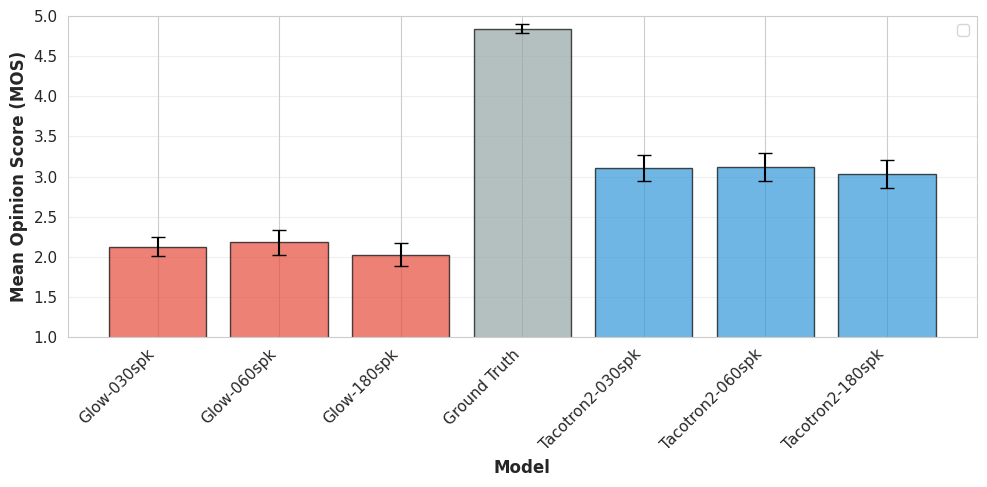

In [32]:
fig, ax = plt.subplots(figsize=(10, 5))

models = mos_results.index
mos_values = mos_results["MOS"].values
ci_margins = mos_results["CI_margin"].values

colors = [
    "#3498db" if "Tacotron" in m else "#e74c3c" if "Glow" in m else "#95a5a6"
    for m in models
]

ax.bar(
    range(len(models)),
    mos_values,
    yerr=ci_margins,
    capsize=5,
    color=colors,
    alpha=0.7,
    edgecolor="black",
)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Mean Opinion Score (MOS)", fontsize=12, fontweight="bold")
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha="right")
ax.set_ylim(1, 5)
# ax.axhline(y=3.0, color="gray", linestyle="--", alpha=0.5, label="MOS=3.0")
ax.grid(axis="y", alpha=0.3)
ax.legend()

plt.tight_layout()
plt.savefig("../latex/paper/figures/mos_by_model.png")
plt.show()

### 4.2 Architecture Comparison (Tacotron 2 vs Glow-TTS)

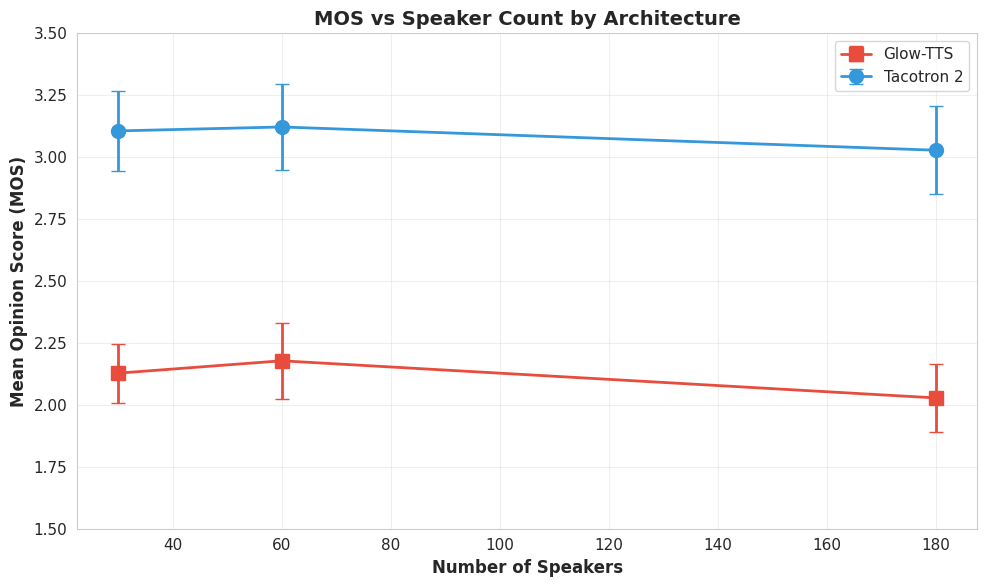

In [15]:
# Parse model names to extract architecture and speaker count
def parse_model_name(name):
    if "Tacotron" in name or "Taco" in name:
        arch = "Tacotron 2"
    elif "Glow" in name:
        arch = "Glow-TTS"
    elif "GT" in name or "Ground" in name:
        return "Ground Truth", 0
    else:
        arch = "Other"

    import re

    spk_match = re.search(r"(\d+)spk", name, re.IGNORECASE)
    spk_count = int(spk_match.group(1)) if spk_match else 0

    return arch, spk_count


# Add architecture and speaker count columns
mos_results["Architecture"] = mos_results.index.map(lambda x: parse_model_name(x)[0])
mos_results["Speakers"] = mos_results.index.map(lambda x: parse_model_name(x)[1])

# Filter out ground truth
exp_results = mos_results[mos_results["Speakers"] > 0].copy()

fig, ax = plt.subplots(figsize=(10, 6))

for arch in exp_results["Architecture"].unique():
    arch_data = exp_results[exp_results["Architecture"] == arch].sort_values("Speakers")
    color = "#3498db" if arch == "Tacotron 2" else "#e74c3c"
    marker = "o" if arch == "Tacotron 2" else "s"

    ax.errorbar(
        arch_data["Speakers"],
        arch_data["MOS"],
        yerr=arch_data["CI_margin"],
        marker=marker,
        markersize=10,
        linewidth=2,
        capsize=5,
        label=arch,
        color=color,
    )

ax.set_xlabel("Number of Speakers", fontsize=12, fontweight="bold")
ax.set_ylabel("Mean Opinion Score (MOS)", fontsize=12, fontweight="bold")
ax.set_title("MOS vs Speaker Count by Architecture", fontsize=14, fontweight="bold")
ax.set_ylim(1.5, 3.5)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11)

plt.tight_layout()
plt.show()

### 4.3 Distribution of Ratings (Box Plot)

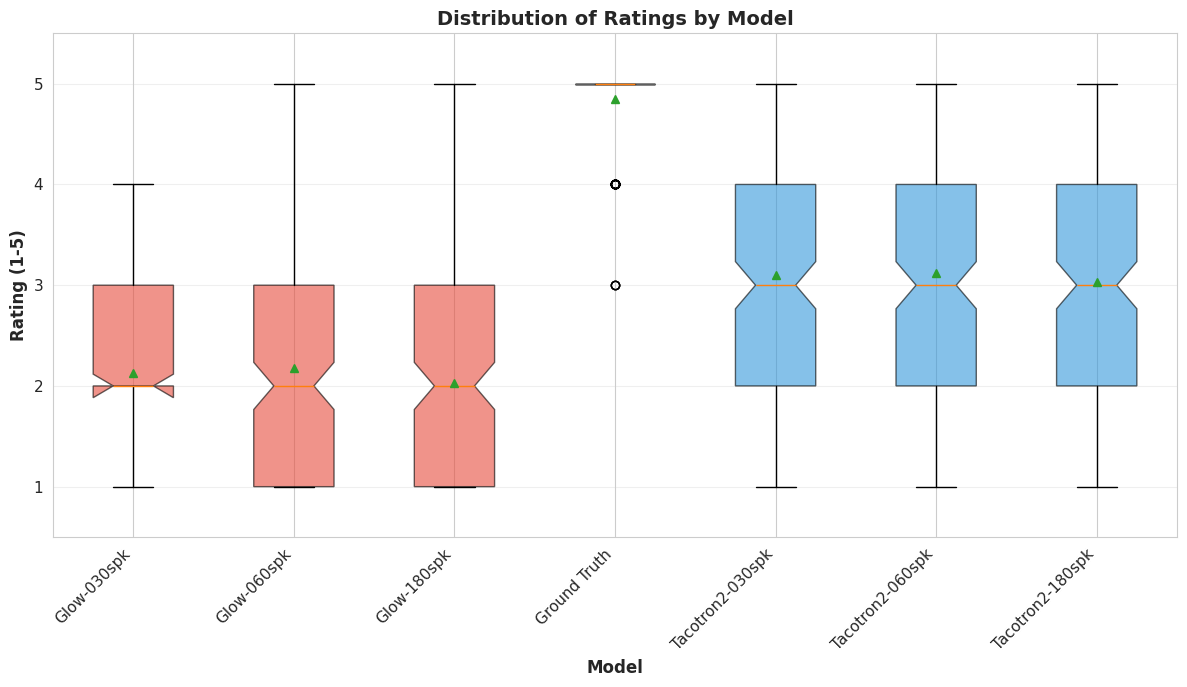

In [52]:
fig, ax = plt.subplots(figsize=(12, 7))
model_names_sorted = sorted(model_names)

bp = ax.boxplot(
    [group["rating"].values for name, group in df.groupby("model_name")],
    labels=model_names_sorted,
    patch_artist=True,
    notch=True,
    showmeans=True,
)

for patch, model in zip(bp["boxes"], model_names_sorted):
    if "Tacotron" in model or "Taco" in model:
        patch.set_facecolor("#3498db")
    elif "Glow" in model:
        patch.set_facecolor("#e74c3c")
    else:
        patch.set_facecolor("#95a5a6")
    patch.set_alpha(0.6)

ax.set_xlabel("Model", fontsize=12, fontweight="bold")
ax.set_ylabel("Rating (1-5)", fontsize=12, fontweight="bold")
ax.set_title("Distribution of Ratings by Model", fontsize=14, fontweight="bold")
ax.set_xticklabels(model_names_sorted, rotation=45, ha="right")
ax.grid(axis="y", alpha=0.3)
ax.set_ylim(0.5, 5.5)

plt.tight_layout()
plt.show()

### 4.4 Per-Speaker Analysis


AVERAGE MOS PER SPEAKER (across all models)
             MOS  CI_margin      n
speaker_id                        
MS052       2.48       0.17  210.0
VP131       2.56       0.17  210.0
VP427       2.61       0.18  210.0
IS031       3.00       0.18  210.0
IS038       3.27       0.16  210.0
AS009       3.60       0.18  210.0


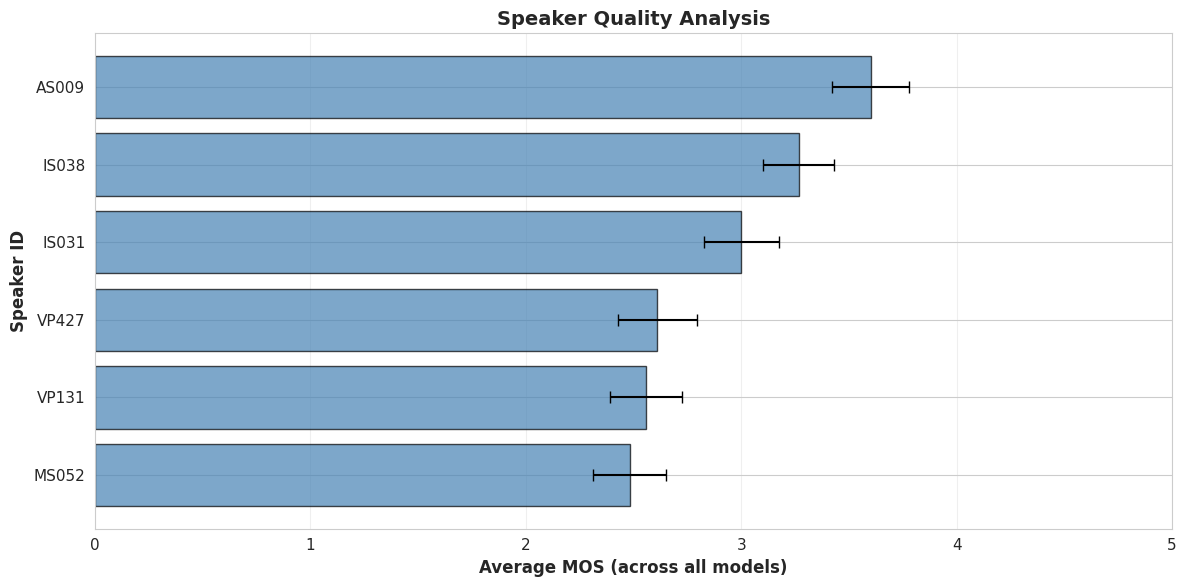

In [55]:
# Calculate average MOS per speaker
speaker_mos = (
    df.groupby("speaker_id")["rating"]
    .apply(lambda x: pd.Series(calculate_mos_with_ci(x)))
    .unstack()
    .sort_values("MOS", ascending=True)
)

print("\n" + "=" * 80)
print("AVERAGE MOS PER SPEAKER (across all models)")
print("=" * 80)
print(speaker_mos[["MOS", "CI_margin", "n"]].round(2))

# Plot per-speaker MOS
fig, ax = plt.subplots(figsize=(12, 6))

speakers = speaker_mos.index
mos_vals = speaker_mos["MOS"].values
ci_vals = speaker_mos["CI_margin"].values

ax.barh(
    range(len(speakers)),
    mos_vals,
    xerr=ci_vals,
    capsize=4,
    alpha=0.7,
    color="steelblue",
    edgecolor="black",
)

ax.set_yticks(range(len(speakers)))
ax.set_yticklabels(speakers)
ax.set_xlabel("Average MOS (across all models)", fontsize=12, fontweight="bold")
ax.set_ylabel("Speaker ID", fontsize=12, fontweight="bold")
ax.set_title("Speaker Quality Analysis", fontsize=14, fontweight="bold")
ax.set_xlim(0, 5)
ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


SPEAKER MOS BY ARCHITECTURE
architecture  Glow-TTS  Tacotron 2  Difference
speaker_id                                    
AS009             2.61        4.17        1.56
VP427             1.60        2.92        1.32
IS031             2.13        3.26        1.12
IS038             2.51        3.48        0.97
VP131             1.93        2.43        0.50
MS052             1.88        2.26        0.38

Average Tacotron 2 advantage: 0.97 MOS points
Standard deviation: 0.46


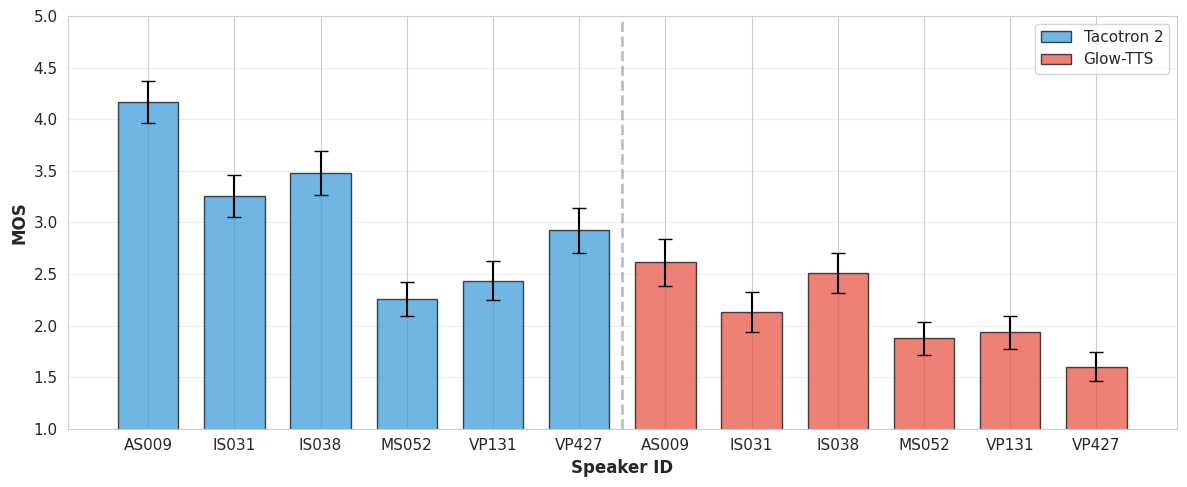

In [41]:
# Add architecture column to df
df["architecture"] = df["model_name"].apply(lambda x: parse_model_name(x)[0])

# Filter for Tacotron 2 and Glow-TTS only
arch_comparison = df[df["architecture"].isin(["Tacotron 2", "Glow-TTS"])].copy()

# Calculate MOS per speaker per architecture
speaker_arch_mos = (
    arch_comparison.groupby(["speaker_id", "architecture"])["rating"]
    .apply(lambda x: pd.Series(calculate_mos_with_ci(x)))
    .unstack()
)

# Pivot to compare architectures
mos_pivot = speaker_arch_mos["MOS"].unstack(level=1)
ci_pivot = speaker_arch_mos["CI_margin"].unstack(level=1)
mos_pivot["Difference"] = mos_pivot["Tacotron 2"] - mos_pivot["Glow-TTS"]

print("\n" + "=" * 80)
print("SPEAKER MOS BY ARCHITECTURE")
print("=" * 80)
print(mos_pivot.sort_values("Difference", ascending=False).round(2))

# Calculate average difference
avg_diff = mos_pivot["Difference"].mean()
print(f"\nAverage Tacotron 2 advantage: {avg_diff:.2f} MOS points")
print(f"Standard deviation: {mos_pivot['Difference'].std():.2f}")

# Visualize speaker-level differences grouped by architecture
fig, ax = plt.subplots(figsize=(12, 5))

speakers = mos_pivot.index
n_speakers = len(speakers)
width = 0.7

# Create positions for bars: group by architecture
taco_positions = np.arange(n_speakers)
glow_positions = np.arange(n_speakers, 2 * n_speakers)

ax.bar(
    taco_positions,
    mos_pivot["Tacotron 2"],
    width,
    yerr=ci_pivot["Tacotron 2"],
    capsize=5,
    label="Tacotron 2",
    color="#3498db",
    alpha=0.7,
    edgecolor="black",
)
ax.bar(
    glow_positions,
    mos_pivot["Glow-TTS"],
    width,
    yerr=ci_pivot["Glow-TTS"],
    capsize=5,
    label="Glow-TTS",
    color="#e74c3c",
    alpha=0.7,
    edgecolor="black",
)

# Set x-axis labels
all_positions = np.concatenate([taco_positions, glow_positions])
all_labels = list(speakers) + list(speakers)
ax.set_xticks(all_positions)
ax.set_xticklabels(all_labels)

# Add vertical separator line between architectures
ax.axvline(x=n_speakers - 0.5, color="gray", linestyle="--", linewidth=2, alpha=0.5)

# # Add architecture labels
# ax.text(n_speakers / 2 - 0.5, ax.get_ylim()[1] * 0.95, 'Tacotron 2',
#         ha='center', fontsize=13, fontweight='bold', color='#3498db')
# ax.text(n_speakers + n_speakers / 2 - 0.5, ax.get_ylim()[1] * 0.95, 'Glow-TTS',
#         ha='center', fontsize=13, fontweight='bold', color='#e74c3c')

ax.set_xlabel("Speaker ID", fontsize=12, fontweight="bold")
ax.set_ylabel("MOS", fontsize=12, fontweight="bold")
# ax.set_title("MOS per Speaker by Architecture", fontsize=14, fontweight="bold")
ax.set_ylim(1, 5)
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

# # Statistical test: paired t-test
# from scipy.stats import ttest_rel

# t_stat, p_val = ttest_rel(mos_pivot["Tacotron 2"], mos_pivot["Glow-TTS"])

# print("\n" + "=" * 80)
# print("PAIRED T-TEST (Tacotron 2 vs Glow-TTS per speaker)")
# print("=" * 80)
# print(f"t-statistic: {t_stat:.4f}")
# print(f"p-value: {p_val:.6f}")
# print(f"Significant at α=0.05? {'YES' if p_val < 0.05 else 'NO'}")

### 4.5 Speaker Performance by Architecture

## 5. Summary Statistics for Thesis

In [16]:
print("\n" + "=" * 80)
print("SUMMARY FOR THESIS")
print("=" * 80)

print("\n1. Total number of ratings:", len(df))
print("2. Number of unique raters:", df["user_email_hash"].nunique())
print("3. Number of models evaluated:", df["model_name"].nunique())
print("4. Rating scale: 1-5")

print("\n5. Overall rating distribution:")
rating_dist = df["rating"].value_counts().sort_index()
for rating, count in rating_dist.items():
    pct = 100 * count / len(df)
    print(f"   Rating {rating}: {count} ({pct:.1f}%)")

print("\n6. Top 3 performing models:")
top_models = mos_results.nlargest(3, "MOS")
for i, (model, row) in enumerate(top_models.iterrows(), 1):
    print(f"   {i}. {model}: {row['MOS']:.2f} ± {row['CI_margin']:.2f}")

print("\n7. Statistical significance:")
print(f"   ANOVA F-statistic: {f_stat:.4f}")
print(f"   ANOVA p-value: {p_value:.6f}")
print(f"   Number of significant pairwise differences: {len(significant_pairs)}")


SUMMARY FOR THESIS

1. Total number of ratings: 1260
2. Number of unique raters: 21
3. Number of models evaluated: 7
4. Rating scale: 1-5

5. Overall rating distribution:
   Rating 1: 201 (16.0%)
   Rating 2: 345 (27.4%)
   Rating 3: 304 (24.1%)
   Rating 4: 175 (13.9%)
   Rating 5: 235 (18.7%)

6. Top 3 performing models:
   1. GT-000000: 4.84 ± 0.06
   2. Tacotron2-060spk: 3.12 ± 0.17
   3. Tacotron2-030spk: 3.11 ± 0.16

7. Statistical significance:
   ANOVA F-statistic: 177.9131
   ANOVA p-value: 0.000000
   Number of significant pairwise differences: 15


## 7. Save Processed Results

In [18]:
# mos_results.to_csv('../results/mos_summary.csv')
# print("MOS summary saved to: results/mos_summary.csv")

# tukey_df.to_csv('../results/tukey_hsd_results.csv', index=False)
# print("Tukey HSD results saved to: results/tukey_hsd_results.csv")

# print("\nAnalysis complete!")